In [1]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras

In [2]:
from datetime import datetime, timedelta
import pandas_datareader as pdr

In [3]:
# define time interval
end_time   = datetime.today() - timedelta(days=1)
start_time = datetime(end_time.year - 10, end_time.month, end_time.day)
sp500      = pdr.DataReader('^GSPC','yahoo',start_time,end_time)
sp500 = sp500.reset_index(level=0)
sp500

,Date,High,Low,Open,Close,Volume,Adj Close
0,2012-09-26,1441.599976,1430.530029,1441.599976,1433.319946,3565380000,1433.319946
1,2012-09-27,1450.199951,1433.359985,1433.359985,1447.150024,3150330000,1447.150024
2,2012-09-28,1447.130005,1435.599976,1447.130005,1440.670044,3509230000,1440.670044
3,2012-10-01,1457.140015,1440.900024,1440.900024,1444.489990,3505080000,1444.489990
4,2012-10-02,1451.520020,1439.010010,1444.989990,1445.750000,3321790000,1445.750000
...,...,...,...,...,...,...,...
2511,2022-09-20,3876.010010,3827.540039,3875.229980,3855.929932,4058050000,3855.929932
2512,2022-09-21,3907.070068,3789.489990,3871.399902,3789.929932,4078330000,3789.929932
2513,2022-09-22,3790.899902,3749.449951,3782.360107,3757.989990,4284600000,3757.989990
2514,2022-09-23,3727.139893,3647.469971,3727.139893,3693.229980,5144270000,3693.229980


In [5]:
sp500['Target'] = sp500[['Close']].shift(-1)
sp500 = sp500[:-1]
sp500 = sp500.drop(columns=["High", "Low", "Open", "Adj Close"])

In [6]:
sp500

,Date,Close,Volume,Target
0,2012-09-26,1433.319946,3565380000,1447.150024
1,2012-09-27,1447.150024,3150330000,1440.670044
2,2012-09-28,1440.670044,3509230000,1444.489990
3,2012-10-01,1444.489990,3505080000,1445.750000
4,2012-10-02,1445.750000,3321790000,1450.989990
...,...,...,...,...
2510,2022-09-19,3899.889893,3766850000,3855.929932
2511,2022-09-20,3855.929932,4058050000,3789.929932
2512,2022-09-21,3789.929932,4078330000,3757.989990
2513,2022-09-22,3757.989990,4284600000,3693.229980


In [9]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
sp500_scaled = sc.fit_transform(sp500.drop(columns = ['Date']))

In [21]:
sp500_scaled.shape

(2515, 3)

In [10]:
# Creating Feature and Target
X = sp500_scaled[:,:2]
y = sp500_scaled[:,2:]

In [11]:
split = int(0.8 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

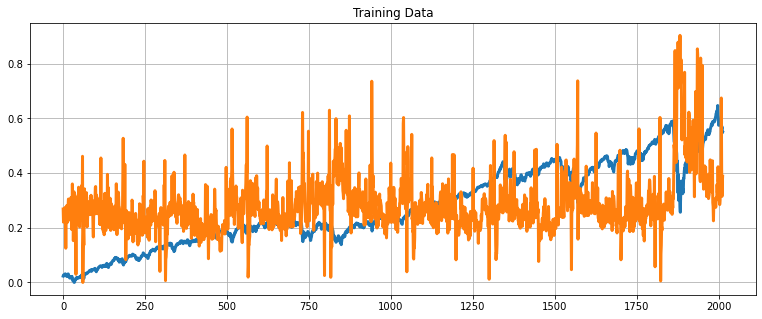

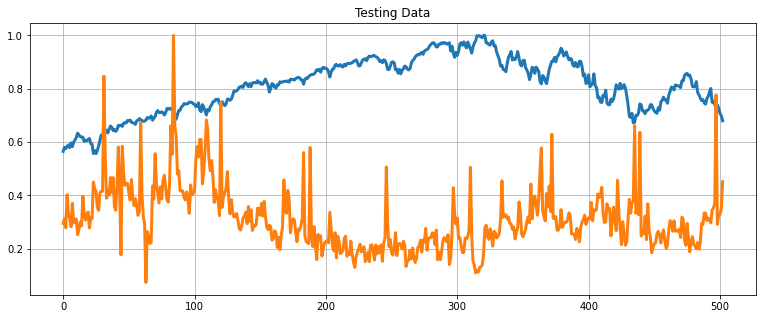

In [12]:
def show_plot(data, title):
    plt.figure(figsize = (13, 5))
    plt.plot(data, linewidth = 3)
    plt.title(title)
    plt.grid()

show_plot(X_train, 'Training Data')
show_plot(X_test, 'Testing Data')

## Linear Regression

In [13]:
from sklearn.linear_model import Ridge
# Note that Ridge regression performs linear least squares with L2 regularization.
# Create and train the Ridge Linear Regression  Model
regression_model = Ridge(alpha=0.4)
regression_model.fit(X_train, y_train)

Ridge(alpha=0.4)

In [14]:
# Test the model and calculate its accuracy 
lr_accuracy = regression_model.score(X_test, y_test)
print("Linear Regression Score: ", lr_accuracy)

Linear Regression Score:  0.9801437903756967


In [15]:
predicted_prices = regression_model.predict(X)
predicted_prices

array([[0.02615014],
       [0.0300442 ],
       [0.02825155],
       ...,
       [0.70349956],
       [0.69436055],
       [0.67591629]])

In [25]:
predicted_prices.shape

(2515, 1)

In [30]:
predicted = pd.DataFrame({'Date': sp500['Date'], 'Close': sp500_scaled[:, 0], "Prediction_Regression": predicted_prices.flatten()})

In [31]:
predicted

,Date,Close,Prediction_Regression
0,2012-09-26,0.023231,0.026150
1,2012-09-27,0.027248,0.030044
2,2012-09-28,0.025366,0.028252
3,2012-10-01,0.026475,0.029349
4,2012-10-02,0.026841,0.029675
...,...,...,...
2510,2022-09-19,0.739585,0.735040
2511,2022-09-20,0.726818,0.722463
2512,2022-09-21,0.707649,0.703500
2513,2022-09-22,0.698373,0.694361


In [32]:
def interactive_plot(df, title):
    fig = px.line(title = title)
    for i in df.columns[1:]:
        fig.add_scatter(x = df['Date'], y = df[i], name = i)
    fig.show()

In [33]:
interactive_plot(predicted, "Original Vs. Prediction")

## LSTM

In [34]:
# Reshape the 1D arrays to 3D arrays to feed in the model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((2012, 2, 1), (503, 2, 1))

In [35]:
# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences= True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 2, 150)            91200     
                                                                 
 dropout (Dropout)           (None, 2, 150)            0         
                                                                 
 lstm_1 (LSTM)               (None, 2, 150)            180600    
                                                                 
 dropout_1 (Dropout)         (None, 2, 150)            0         
                                                                 
 lstm_2 (LSTM)               (None, 150)               180600    
                                                                 
 dense (Dense)               (None, 1)                 151   

In [36]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.2
)

Epoch 1/20
51/51 [==============================] - 6s 22ms/step - loss: 0.0151 - val_loss: 0.0213
Epoch 2/20
51/51 [==============================] - 1s 11ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 3/20
51/51 [==============================] - 0s 6ms/step - loss: 5.6300e-04 - val_loss: 0.0015
Epoch 4/20
51/51 [==============================] - 0s 6ms/step - loss: 4.7260e-04 - val_loss: 0.0013
Epoch 5/20
51/51 [==============================] - 0s 6ms/step - loss: 4.1980e-04 - val_loss: 0.0011
Epoch 6/20
51/51 [==============================] - 0s 8ms/step - loss: 3.6869e-04 - val_loss: 0.0011
Epoch 7/20
51/51 [==============================] - 0s 9ms/step - loss: 3.2860e-04 - val_loss: 8.8783e-04
Epoch 8/20
51/51 [==============================] - 0s 8ms/step - loss: 3.4083e-04 - val_loss: 8.6183e-04
Epoch 9/20
51/51 [==============================] - 0s 8ms/step - loss: 3.0318e-04 - val_loss: 7.9114e-04
Epoch 10/20
51/51 [==============================] - 0s 6ms/step - loss: 2.7

In [37]:
LSTM_predicted = model.predict(X)

In [38]:
predicted["LSTM_prediction"] =LSTM_predicted

In [39]:
interactive_plot(predicted, "Original Vs. Prediction")

In [40]:
predicted["LSTM"] = predicted["LSTM_prediction"] - predicted["Close"]
predicted["regression"] = predicted["Prediction_Regression"] - predicted["Close"]

In [44]:
diff = predicted.drop(columns = ["Close","LSTM_prediction", "Prediction_Regression"])

In [45]:
interactive_plot(diff, "differences")